# Quantifying the World: Case Study 3
Eric Romero, Patricia Attah, Antonio Debouse

### Table of Contents:

   * <a href="#1"> Business Understanding </a>
   * <a href="#2"> Data Evaluation/Engineering </a>
   * <a href="#3"> Modeling Preparations </a>
   * <a href="#4"> Model Building and Evaluation </a>
   * <a href="#5"> Model Interpretability and Explainability </a>
   * <a href="#6"> Case Conclusions </a>

<a id="1"></a>
## Business Understanding
An IT Department identified that company employees have been receiving a large amount of spam emails and request that we create a dataset that is a collection of both spam and normal emails, then build a model to identify spam and non-spam emails. We, the data scientist, will be using a Clustering and Naïve Bayes method to create an email filter that will improve emails that gets put into our inbox and those that are placed into a “spam” folder. Our model evaluation metric will be precision given we are prioritizing being able to predict a normal (true positive); we do not want to miss reading important emails because they were identified as spam.  


### Task Summary:
* Build a spam classifier using naive Bayes and clustering.
* Our critical evaluation metric is Precision because this is used when the predicted positives are crucial. 
    * We will prioritize genuine emails being classified as spam to as low as possible given that crucial information would be lost and may cause more serious problems.


<a id="2"></a>
## Data Evaluation/Engineering

In [5]:
import numpy as np
import sys
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd
import re
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tarfile
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix

def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        chdir('C:/Users/Eric/Documents/GitHub/QuantifyingTheWorld')

    active_dir = getcwd()
       
    return active_dir

In [6]:
%%time
def main():
    
    get_cwd()
    
    directories = [
            'sample_spam',
            'sample_ham'
        ]
    
    res_frame = pd.DataFrame()
    
    # Added to generate a list of text strings
    text_list = []
    #####
        
    for d in directories:
        mypath = getcwd() + '/SpamAssassinMessages/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            # Will be appended to as the email is "read in"
            temp_text_list = ''
            #####
            
            for line in lines:
               n_lines += 1
               if "Subject: Re: " in line:
                   in_reply_count += 1
               if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
               if "content-type: multipart" in line.lower():
                   attachments += 1
               if line == "\n":
                   blank_lines.append(n_lines)

               # Appends the current line to the existing string
               temp_text_list += ' ' + line
            
            # Formats the complete email string (removing new lines and whitespaces)
            temp_text_list = temp_text_list.replace('\n', ' ').replace('\r', '')
            temp_text_string = re.sub(' +', ' ', temp_text_list)   
            text_list.append(temp_text_string)
            #####
            
        
            temp_frame = pd.DataFrame({
                        'filename':file,
                        'is_spam':[1 if 'spam' in d else 0],
                        'in_reply': [1 if in_reply_count > 0 else 0], 
                        'subj_caps': [1 if sub_line_all_caps > 0 else 0], 
                        'attachments': [1 if attachments > 0 else 0], 
                        'body_lines': n_lines - min(blank_lines)
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)
            
    res_frame.to_csv('output_file.csv', index=False)
    
    return res_frame, text_list # text_list is new

########################################
##### Main Function
########################################    

if __name__ == "__main__":
    res_frame, corpus = main()
    pass        

Wall time: 12.9 s


In [7]:
res_frame.isnull().sum() #count of missing values by feature

filename       0
is_spam        0
in_reply       0
subj_caps      0
attachments    0
body_lines     0
dtype: int64

* Data preparation was created from multiple email files and types sorted by into two categories of sampled spam and non-spam.
    * Due to limitaions of our computer systems we chose to sample selections from each type of the email files by reducing the total number of emails processed down to 1000 combined.  This was necessary as our system ran into crashes or memory errors when any number was attempted beyond this amount.
    * The 1000 emails were sampled as follows:
        * 500 spam
        * 300 ham
        * 200 hard ham (emails that were more difficult to recognize as not spam)
        
        
* As emails were processed, a dataset was created that recorded the following categorical and numerical information for each:
    * The filename for identification purposes. (categorical)
    * Category of email type spam or non-spam. (categorical)
    * Whether they email was marked as a reply to a previous email. (categorical)
    * If the subject line was in all capitalized lettering. (categorical)
    * Whether the email contained an attachment or not. (categorical)
    * The number of body lines contained in the email (numerical)
    
    
* Additionally the text of each email was recorded as a corpus and vectorized for use in the vocabulary analysis of words particular to the spam type emails.


* No values are missing for this dataset


* The "filename" attribute will be meaningless for analysis therefore this will be dropped from the data to improve performance.


* Assumptions for this dataset based on selected models:
    * Naive Bayes Model:
        * Data features are assumed to be independent of each other.
    * K-Means
        * Clusters are sphericial in shape and of similar sizes.    


<a id="3"></a>
## Modeling Preparation and EDA

(array([1, 0]), <a list of 2 Text xticklabel objects>)

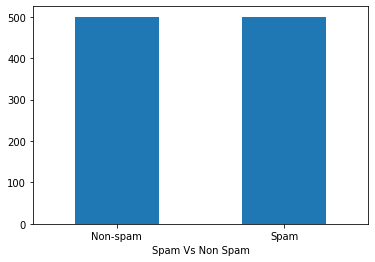

In [4]:
res_frame['is_spam'].value_counts().sort_values().plot(kind = 'bar')
plt.xticks([1,0],['Spam','Non-spam'])
plt.xlabel('Spam Vs Non Spam')
plt.xticks(rotation=0)

##### Spam count Vs Non Spam count
The counts of spam vs non-spam are the same since our computer system could not run the full number of emails we sampled equal numbers of spam and non spam emails with 2/5 of the non-spam being comprised of the "hard-ham" email variety to stay consistent with the variation of email types.

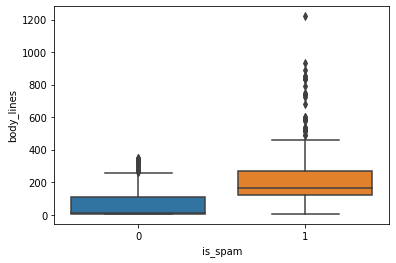

In [6]:
ax = sns.boxplot(x="is_spam", y="body_lines", data=res_frame)

<b>Bar Chart1</b>: We see that the number of lines in the spam email is significantly higher than the number of lines for the non spam email, so there are chances that the longer the email is it is spam. the median number of lines for spam emails were about 100 while for the number of lines for emial were about 20.

In [5]:
#res_frame.head()

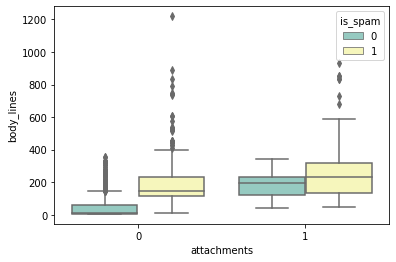

In [7]:
ax = sns.boxplot(x="attachments", y="body_lines", hue="is_spam", 
...                  data=res_frame, palette="Set3")

<b>Bar Chart2</b>: We see that for spam emails there was a higher number of body lines as well as a higher rate of attachments in comparison to non-spam emails. Spam emails with attachments had a body line count of about 120 while the spam without attachemnts had a median body line count of about 80, so generally a large number of spam comes with attachments.

<a id="4"></a>
## Modeling Building and Evaluation

A Naive Bayes classifier will first be used to train a email categories which will then be run on a test set for comparison. This method is appropriate for this task as it calculates the categories of the emails based on probability of occurrence for each email.

*Methods to solve Naive Bayes:*
1. Import emails to create dataset.
2. Vectorize email text to create word count attributes for the data.
3. Filter stop words to reduce unnecessary text attributes and improve performance.  
4. Use naive model to predict category of email for a test set
5. Run confusion matrix to measure Accuracy and Precision metrics for predicted categories.

K-means clustering will be used to separate the data into groups within the data based on similarities they share. This is an appropriate modeling technique as spam emails will typically contain similar text patterns or attributes that if identified as a cluster will assist in their categorization.

*Method to solve Kmeans:*
1. Import emails to create dataset.
2. Find appropriate number of clusters (k) using elbow method and silhouette scores
3. Create data pipeline to reduce any data leaks.
4. Peform PCA for the two target clusters.
5. Run confusion matrix to measure Accuracy and Precision metrics for predicted clusters.

*Critical Metric (Precision)*

Our critical evaluation metric for both methods will be Precision because this is used when the predicted positives are crucial. In the case of email importance if a crucial email is classified as spam important information will be lost and may cause serious problems.

### Naive Bayes Classifier

In [8]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', stop_words='english', ngram_range=(2,2)) #removes stop_words from text
X = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())

CPU times: user 1.24 s, sys: 38.4 ms, total: 1.28 s
Wall time: 1.33 s


In [9]:
%%time
y = res_frame['is_spam'].values


from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(accuracy_score(clf.predict(X_test), y_test)))
    
df = pd.DataFrame(data=X.toarray(), columns=[vectorizer.get_feature_names()])
#df.to_csv('C:/Users/Eric/Documents/GitHub/QuantifyingTheWorld/wide_df.csv', index=False)
#df.T.to_csv('C:/Users/Eric/Documents/GitHub/QuantifyingTheWorld/long_df.csv')


combined_df = pd.concat([res_frame, df], axis=1)



Accuracy of Naive Bayes classifier on test set: 0.97
CPU times: user 2.61 s, sys: 1.24 s, total: 3.86 s
Wall time: 4.22 s


In [10]:
combined_df

,filename,is_spam,in_reply,subj_caps,attachments,body_lines,"(00 00,)","(00 000,)","(00 0000,)","(00 01,)",...,"(þ³é iän,)","(þà çò,)","(þàì ááàº,)","(þàìå ¾ææ¼½ºæ,)","(þàï àô,)","(þàïà ¹ß¼ûçø¼,)","(þàïà áö,)","(þàïà áö½ã,)","(þàïàº åë½å,)","(þàïáö¼ò çîáß,)"
0,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,0,0,1,157,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0395.bb934e8b4c39d5eab38f828a26f760b4,1,0,0,1,242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00012.cb9c9f2a25196f5b16512338625a85b4,1,0,0,0,136,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0485.9021367278833179285091e5201f5854,1,0,0,0,87,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00214.1367039e50dc6b7adb0f2aa8aba83216,1,0,0,1,171,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,02004.58880d4612fa6d656058f7d919a8a931,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1838.d038cbb36f734c5ddbb023d074711d10,0,0,0,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,01725.80327e3b2580e1e277165899b2532871,0,0,0,0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,02178.efa76e272d764da2a8392d836722e5f9,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#Sample NaiveBays Prediction
print(clf.predict(X[5])) 
print(clf.predict_proba(X[5]))   

[1]
[[0. 1.]]


In [12]:
from sklearn.metrics import classification_report
#1 is spam, 0 is not spam
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       165
           1       1.00      0.94      0.97       165

    accuracy                           0.97       330
   macro avg       0.97      0.97      0.97       330
weighted avg       0.97      0.97      0.97       330



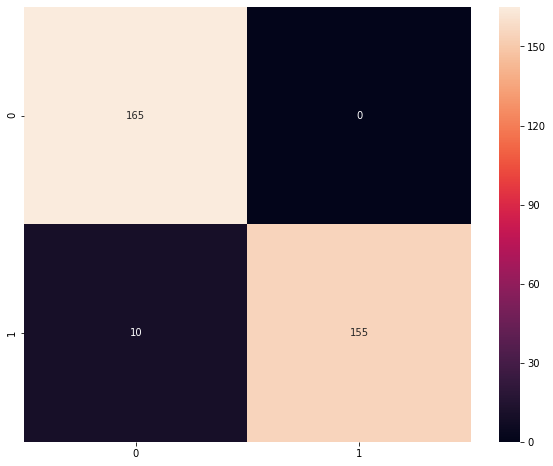

In [13]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cf_test_matrix, annot=True, fmt='d')

### Clustering

In [14]:
%%time
#attr_df = pd.read_csv('output_file.csv')
encoded_df = combined_df.drop(['filename'], axis=1)

encoded_df

CPU times: user 1.72 s, sys: 3.05 s, total: 4.77 s
Wall time: 5.95 s


,is_spam,in_reply,subj_caps,attachments,body_lines,"(00 00,)","(00 000,)","(00 0000,)","(00 01,)","(00 0100,)",...,"(þ³é iän,)","(þà çò,)","(þàì ááàº,)","(þàìå ¾ææ¼½ºæ,)","(þàï àô,)","(þàïà ¹ß¼ûçø¼,)","(þàïà áö,)","(þàïà áö½ã,)","(þàïàº åë½å,)","(þàïáö¼ò çîáß,)"
0,1,0,0,1,157,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,242,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,136,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,87,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,171,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
%%time
y_enc = encoded_df['is_spam']
X_enc = encoded_df.drop(['is_spam'], axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_enc, y_enc, test_size=0.33, random_state=42)

CPU times: user 1.37 s, sys: 1.71 s, total: 3.08 s
Wall time: 3.54 s


### K-Means Clustering

In [16]:
%%time
# SumSquareError values for each k 1-7
sse = []
for k in range(1, 7):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(encoded_df)
    sse.append(kmeans.inertia_)

CPU times: user 7min 32s, sys: 2min 11s, total: 9min 43s
Wall time: 10min 12s


### Elbow Join Method for Selection of K-Clusters

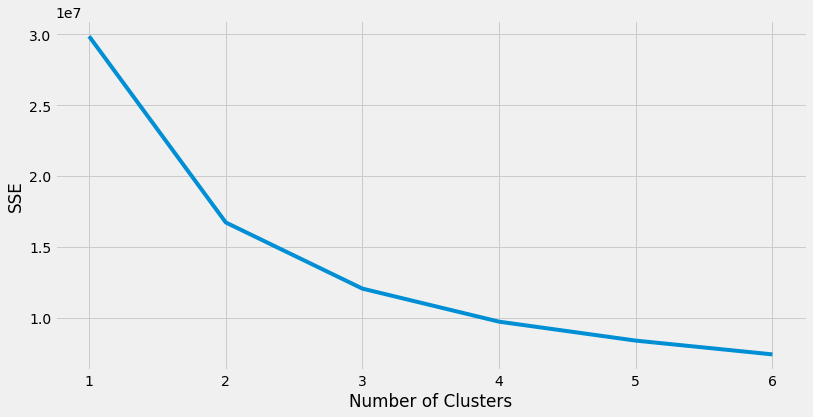

In [17]:
#Elbow Joint Method for Best Number of Clusters 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
plt.plot(range(1, 7), sse)
plt.xticks(range(1, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhouette Score for Selection of K-Clusters

In [18]:
%%time
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(encoded_df)
    score = silhouette_score(encoded_df, kmeans.labels_)
    silhouette_coefficients.append(score)

CPU times: user 7min 32s, sys: 1min 57s, total: 9min 29s
Wall time: 9min 48s


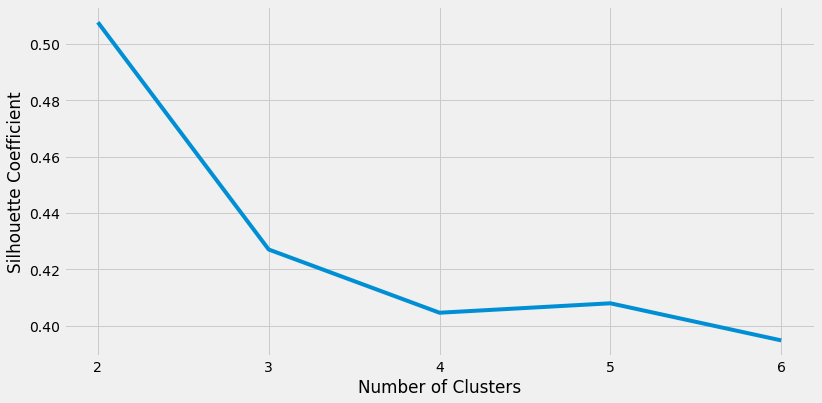

In [19]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [20]:
n_clusters = 2 #Clusters based on highest sil score

### K-Means Clustering Pipeline

In [29]:
%%time
#PCA for dimensionality reduction
preprocessor = Pipeline([("scaler", MinMaxScaler()),("pca", PCA(n_components=2, random_state=42)),])
clusterer = Pipeline([("kmeans", KMeans(n_clusters=n_clusters,init="k-means++",n_init=50,max_iter=500,random_state=42,),),])
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])
pipe.fit(X_test2)

CPU times: user 6.08 s, sys: 1.03 s, total: 7.11 s
Wall time: 4.56 s


Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=2, n_init=50, n_jobs=None,
                                         precomp

In [30]:
%%time
preprocessed_data = pipe["preprocessor"].transform(X_test2)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

CPU times: user 644 ms, sys: 309 ms, total: 954 ms
Wall time: 928 ms


0.9765743875122482

In [31]:
pcadf = pd.DataFrame(pipe["preprocessor"].transform(X_test2),columns=["component_1", "component_2"],)
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

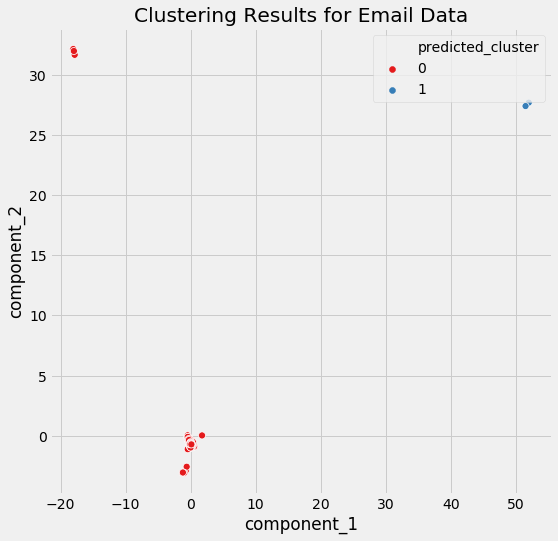

In [32]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(x="component_1",y="component_2",s=50,data=pcadf,hue="predicted_cluster",palette="Set1")
scat.set_title("Clustering Results for Email Data")
plt.show()

In [33]:
preprocessor.steps[1][1].noise_variance_

1.1079071689303333

In [34]:
accuracy_score(y_test2, predicted_labels)

0.5060606060606061

In [35]:
y_pred2 = predicted_labels
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       165
           1       1.00      0.01      0.02       165

    accuracy                           0.51       330
   macro avg       0.75      0.51      0.35       330
weighted avg       0.75      0.51      0.35       330



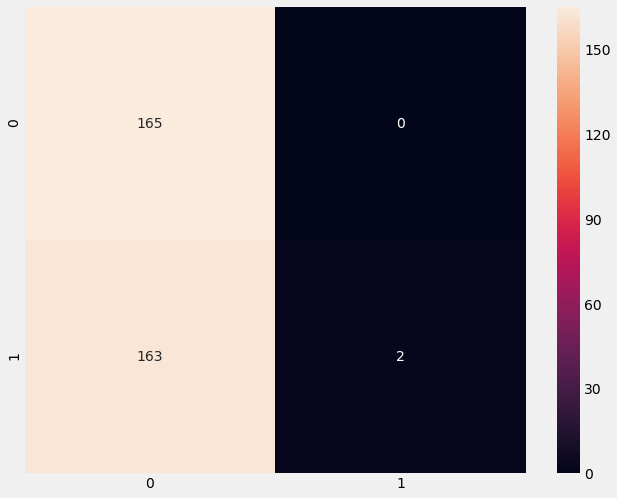

In [36]:
cf_test_matrix = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(10,8))
sns.heatmap(cf_test_matrix, annot=True, fmt='d')

<a id="5"></a>
## Modeling Interpretability and Explainability

### Metric Evaluations

Our critical evaluation metric is Precision because this is used when the predicted positive is crucial. In the case of emails if an important email is misclassified as spam crucial information will be lost and it may cause a serious problem. In this case false positives are more of a concern than the alternative where some spam makes it passed the filter. 
In our first model of Naive bayes our precision for spam was 1.0 so it was a perfect score while it was 0.94 for the correctly predicted emails. The confusion matrix for the Naive bayes model shows that no non-spam emails were misclassified as spam which means the model does well to prioritize emails over spam. Only 10 emails that were spam were wrongly classified as a regular email however this misclassification is not crucial for our purposes as no important information is being lost.

For the Kmeans cluster model the critical metric which is the precision of the class 1 (spam) did very well as it had a perfect score of 1.00, meaning no email was misclassified. The cluster model did very poorly however in classifying spam correctly where approximately half the spam was wrongly identified as legitimate email. Although misclassifying spam is not critical, comparatively to the Naive Bayes model this does a much poorer job at filtering the spam out. This will become a much larger annoyance for clients as most of the spam will still make it through to their email. Clients would need to sort through more emails using this model due the increases in spam, this raises the risk of crucial emails being lost amongst the larger email volume.

<a id="6"></a>
## Case Conclusions

In general the naive bayes classifier is better method for identification of email categories. In addition to not classifying any legitimate emails as spam, it also performed very well in correctly classifying spam emails. Only 10 spam emails were predicted inaccurately which gave a precision of 94%. A low amount of spam making it through the filter was deemed as a more acceptable loss than losing potentially crucial emails that were misclassified as spam.

Moving forward improvements that can be made to the model would be incorporating more samples where possible and within the limits of the computer systems. Further identification and reduction in portions of the email text would also greatly improve the processing speed, which in turn would also allow more sampling to occur by decreasing the corpus size. Identifying more key features that distinguish emails from spam would also improve the model capabilities. Lastly it is also very important that the sample email database be continuously updated with new samples of both spam and non-spam as these tend to change over time, and  spam in particular tends to adapt to filters or use new techniques to appear more genuine.